# Cluster analysis and correlations

Code curretly used for figure 4 in the paper: Heterogeneity of synaptic connectivity in the fly visual system.
<br>This notes includes:
<br><br>A) Clustering: k-mean
<br>B)
<br>C)

In [166]:
# Importing packages
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import pearsonr
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import matplotlib.gridspec as gridspec
from scipy.spatial.distance import hamming
from sklearn.metrics import pairwise_distances
from fafbseg import flywire
import navis

from sklearn.metrics.pairwise import cosine_similarity

### A.  Clustering: k-mean

#### 1. Loading data

Flywire data has been previsouly preanalyzed and stored in an excel file.

In [285]:
# Loading data
PC_disc = 'D'
dataPath = f'{PC_disc}:\Connectomics-Data\FlyWire\Processed-data'
fig_save_path = os.path.join(dataPath,"Figures")

current_data = 'Tm9_700_healthy_L3_R_20231113.xlsx'  # 'Tm9_700_healthy_L3_R_20231113.xlsx' 

filePath =  os.path.join(dataPath,current_data)

data_df = pd.read_excel(filePath, sheet_name='Relative_counts',index_col = 0)
data_df = data_df.fillna(0)
display(data_df.head())
number_of_columns = len(data_df)
print(f'Total number of columns: {number_of_columns}')

,Tm16,Mi4,L3,CT1,Dm12,C3,Tm20,Tm1,ML1,PS125,...,Mt-N.I.,glia,Dm14,Dm8,TmY25,LC14b,Dm2,Dm1,TmY18,MeMe
instance_post,,,,,,,,,,,,,,,,,,,,,
Tm9::R100:D,10.82,17.12,22.52,8.11,0.00,3.60,3.60,2.70,4.50,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tm9::R101:V,0.00,21.70,26.42,12.26,2.83,3.77,2.83,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tm9::R102:V,5.31,8.85,30.09,13.27,2.65,7.08,6.19,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tm9::R103:V,0.00,9.09,29.29,11.11,0.00,0.00,4.04,0.00,0.00,4.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tm9::R104:V,6.34,7.75,23.94,9.86,2.11,5.63,0.00,2.11,2.82,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Total number of columns: 573


#### 2. Selecting data of interest / filtering

This is a interactive cell. You can comment in and out some filtering options as desired.

In [286]:
# picked neurons = ['']
# cluster_df = data_df[['Mi4','CT1']]

# df_excluded = df.drop(columns=columns_to_exclude)

#TODO: Take binary data
# cluster_df = data_df[['Mi4','CT1']]
# neurons_to_exclude = ["L3"]
# data_df = data_df.drop(columns=neurons_to_exclude).copy()


data = data_df.to_numpy()
order = ['L3','Mi4','CT1','Tm16','Dm12','Tm20',
         'C3','Tm1','PS125','L4','ML1','TmY17','C2',
         'OA-AL2b2','Tm2','Mi13','pMP7','Me-Lo-2-N.I.','TmY15']
data_df = data_df[order].copy()

#### 3. K-mean clustering

First we run some analysis to decide which is the most accurate number of clusters that could be found in our data.
The K-mean cluster algorithm will requiered the desired number of clusters as an user input.

Before going into that task, we first should decide if we wanna standaraize or not our data. Whether you need to standardize or normalize your data before applying k-means clustering depends on the scale of the features in your dataset and the sensitivity of the k-means algorithm to the scale of variables. Here are some guidelines to help you decide:

######  a. Scale Sensitivity of K-Means:
K-means clustering is distance-based, meaning it calculates the distance between data points to assign them to clusters. If features are on different scales, features with larger magnitudes may dominate the distance calculations, potentially leading to biased clustering.
Standardizing or normalizing the data helps in ensuring that all features contribute equally to the distance computations.

###### b. Check Feature Scales:
Examine the range of values in each feature. If some features have a much larger scale than others, it might be beneficial to standardize or normalize the data.

###### c. Algorithm Requirements:
Some algorithms, including k-means, are sensitive to the scale of the variables. Standardizing (subtracting the mean and dividing by the standard deviation) or normalizing (scaling to a specific range) can make the algorithm more robust.

###### d. Distance Measures:
If you are using a distance measure other than the default Euclidean distance in k-means (e.g., Manhattan distance), the sensitivity to scale may vary. In some cases, scaling might be less critical.


Steps to Decide Whether to Standardize/Normalize:

##### 1. Visual Inspection:
Plot histograms or box plots of your features to visually inspect their scales.

##### 2. Statistical Summary:

Use descriptive statistics (mean, standard deviation) to understand the scale of each feature.

##### 3. Domain Knowledge:
Consider the nature of your data and the problem domain. In some cases, the natural scale of the features might be more relevant than others.
Algorithm Behavior:

Understand the algorithm's sensitivity to scale and check its documentation. If it explicitly recommends or requires scaling, it's a strong indication that you should do so.

##### 4. Experiment:
Try running k-means with and without scaling and compare the results. Evaluate the cluster quality and interpretability to see if scaling makes a significant difference.

In [287]:
## Data Preprocessing
data[np.isnan(data)] = 0

## Feature scaling
"""
These lines use the MinMaxScaler or StandardScaler from scikit-learn to normalized by min-max or standardize 
# the features by removing the mean and scaling to unit variance.
"""
# Normalize the data using Min-Max scaling (important to simulate Manhattan distance)
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data_df)

# Scale/normalize the original data ( when using an euclidean metric for distances)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_df)

# Apply np.abs to the normalized data to simulate Manhattan distance
data_manhattan = np.abs(data_normalized)


In [288]:
# Select data of interest
data = data # data, data_manhattan, data_scaled

Text(0, 0.5, 'Silhouette Coefficient')

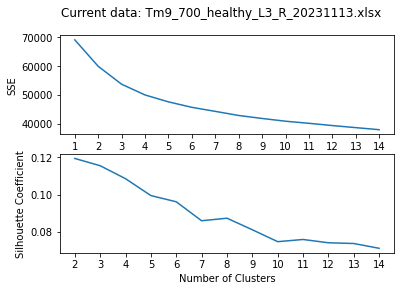

In [289]:
## Determining the Number of Clusters
# The code then proceeds to determine the optimal number of clusters using two methods:

# a. Elbow Method (Sum of Squared Errors - SSE)
"""
This part of the code performs k-means clustering for different values of k and calculates the Sum of Squared Errors (SSE). 
The goal is to identify the "elbow" point in the plot, where the rate of decrease in SSE slows down. This can be an indicator 
of the optimal number of clusters.
"""
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

fig1, axs = plt.subplots(2)
fig1.suptitle(f'Current data: {current_data}')
# A list holds the SSE values for each k
sse = []
max_c = 15
for k in range(1, max_c):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data)
    sse.append(kmeans.inertia_)
    
axs[0].plot(range(1, max_c), sse)
axs[0].set_xticks(range(1, max_c))
axs[0].set_xlabel("Number of Clusters")
axs[0].set_ylabel("SSE")

# b. Silhouette Analysis:
"""
This part calculates the silhouette coefficient for different values of k. The silhouette coefficient measures how similar 
an object is to its own cluster compared to other clusters. A higher silhouette coefficient suggests better-defined clusters.
"""
silhouette_coefficients = []
   
# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, max_c):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data)
    score = silhouette_score(data, kmeans.labels_)
    silhouette_coefficients.append(score)
    
axs[1].plot(range(2, max_c), silhouette_coefficients)
axs[1].set_xticks(range(2, max_c))
axs[1].set_xlabel("Number of Clusters")
axs[1].set_ylabel("Silhouette Coefficient")

Second, we can perfomr k-mean clustering with the desired N clusters

Neurons per cluster: [272 301]
Silhouette Score: 0.1929783956801085


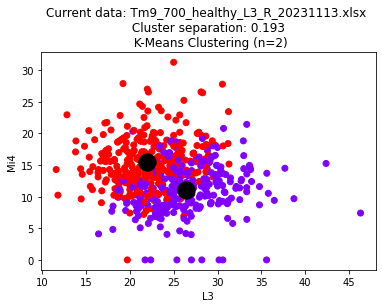

In [290]:
# Perform K means with the desired cluster n
n_k_clusters = 2
kmeans = KMeans(
    init="random",
    n_clusters=n_k_clusters,
    n_init=10,
    max_iter=300,
    random_state=42)
kmeans.fit(data_df)
unique_clusters, counts = np.unique(kmeans.labels_, return_counts=True)
print(f'Neurons per cluster: {counts}')

# Add a new column to the original dataset with the cluster labels
data_df['Cluster'] = kmeans.labels_

# Explore cluster characteristics
cluster_means = data_df.groupby('Cluster').mean()

# Visualize the clusters (for 2D data)
feature_1 = 0
feature_2 = 1


# Get the data points for the selected features
selected_data = data_df.iloc[:, [feature_1, feature_2]].values

# Compute the silhouette score
silhouette_avg = silhouette_score(selected_data, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

fig3, axs = plt.subplots(1)

feature_1_name = data_df.columns[feature_1]
feature_2_name = data_df.columns[feature_2]

axs.scatter(data_df[feature_1_name], data_df[feature_2_name], c=data_df['Cluster'], cmap='rainbow')
axs.scatter(kmeans.cluster_centers_[:, feature_1], kmeans.cluster_centers_[:, feature_2], s=300, c='k')
axs.set_title(f'Current data: {current_data} \n Cluster separation: {round(silhouette_avg,3)} \n K-Means Clustering (n={n_k_clusters})')
axs.set_xlabel(feature_1_name)
axs.set_ylabel(feature_2_name)
plt.show()



Silhouette Score: 0.2412550356197664


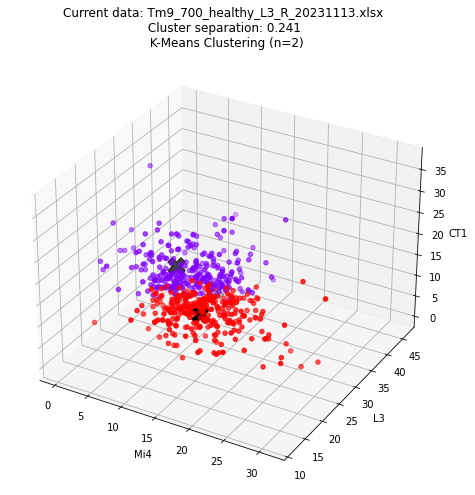

In [291]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Assuming you have a trained KMeans model
kmeans = KMeans(n_clusters=3)
kmeans.fit(data_df)


# Visualize the clusters (for 3D data)
feature_1 = 1
feature_2 = 0
feature_3 = 2  # Add the index of the third feature
feature_1_name = data_df.columns[feature_1]
feature_2_name = data_df.columns[feature_2]
feature_3_name = data_df.columns[feature_3]


# Get the data points for the selected features
selected_data = data_df.iloc[:, [feature_1, feature_2, feature_3]].values

# Compute the silhouette score
silhouette_avg = silhouette_score(selected_data, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for data points
ax.scatter(data_df[feature_1_name], data_df[feature_2_name], data_df[feature_3_name], c=data_df['Cluster'], cmap='rainbow')

# Scatter plot for cluster centers
ax.scatter(kmeans.cluster_centers_[:, feature_1], kmeans.cluster_centers_[:, feature_2], kmeans.cluster_centers_[:, feature_3], s=300, c='k', marker='X')

ax.set_title(f'Current data: {current_data} \n Cluster separation: {round(silhouette_avg,3)} \n K-Means Clustering (n={n_k_clusters})')


ax.set_xlabel(feature_1_name)
ax.set_ylabel(feature_2_name)
ax.set_zlabel(feature_3_name)

plt.show()

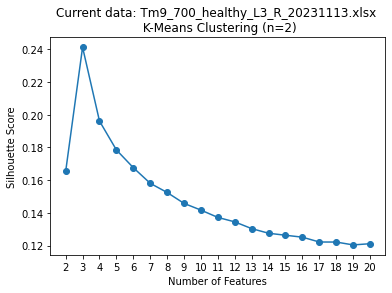

In [292]:
# Iterate over columns to gradually add features
silhouette_avg_ls = []

for i in range(2, len(data_df.columns)+1):
    # Get the data points for the selected features
    selected_data = data_df.iloc[:, :i].values
    
    # Compute the silhouette score
    silhouette_avg = silhouette_score(selected_data, kmeans.labels_)
    silhouette_avg_ls.append(silhouette_avg)

# Plot silhouette scores
plt.plot(range(2, len(data_df.columns) + 1), silhouette_avg_ls, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Silhouette Score')
plt.title(f'Current data: {current_data} \n K-Means Clustering (n={n_k_clusters})')
plt.xticks(range(2, len(data_df.columns) + 1))  # Add ticks based on the number of features
plt.show()








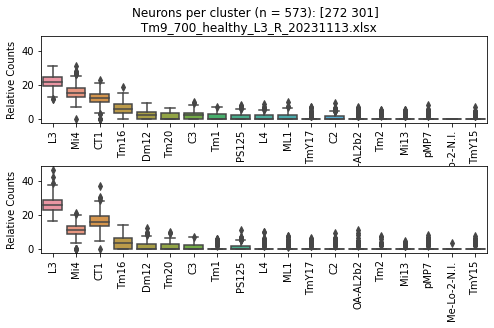

In [297]:
# Plotting box plots for each cluster
## Plotting
# Calculate the number of rows and columns for subplots
num_rows = len(unique_clusters)
num_cols = 1  # Assuming a single column for simplicity, adjust as needed

# Calculate the figure size based on the number of rows
fig_height = 2 * num_rows  # Adjust the multiplier as needed
fig_size = (8, fig_height)

# Adjust subplot spacing and rotate x-axis labels
fig2, axs = plt.subplots(num_rows, num_cols, figsize=fig_size, sharey=True, gridspec_kw={'hspace': 0.5})
fig2.subplots_adjust(hspace=0.5)

#major_inputs_data = data_df[['L3', 'Mi4', 'CT1', 'Tm16', 'Dm12']]
major_inputs_data = data_df[order]

for ax, cluster in zip(axs, unique_clusters):
    sns.boxplot(data=major_inputs_data.iloc[np.where(kmeans.labels_ == cluster)[0]], ax=ax)
    ax.set_ylabel('Relative Counts')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Rotate x-axis labels
    
    

fig2.suptitle(f'Neurons per cluster (n = {number_of_columns}): {counts} \n {current_data}')
plt.show()

Text(0.5, 1.0, 'Difference between Clusters')

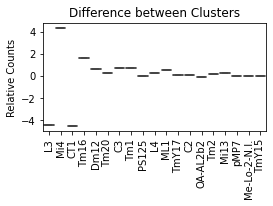

In [302]:
# Create a new figure for the difference plot
fig_diff, ax_diff = plt.subplots(1, 1, figsize=(4, 2))  # Adjust the figsize as needed

# Calculate the difference between the two clusters
diff_data = major_inputs_data.iloc[np.where(kmeans.labels_ == unique_clusters[0])[0]].mean() - \
            major_inputs_data.iloc[np.where(kmeans.labels_ == unique_clusters[1])[0]].mean()

# Create a box plot for the difference
sns.boxplot(data=diff_data.to_frame().T, ax=ax_diff)
ax_diff.set_ylabel('Relative Counts')
ax_diff.set_xticklabels(ax_diff.get_xticklabels(), rotation=90)  # Rotate x-axis labels
ax_diff.set_title('Difference between Clusters')